## Deploy Llava 1.6 with Mistral 7B Endpoint on SageMaker


#### LMI is shipping vLLM 0.4.2 with 0.28.0 containers, so technically we support all LLM that vLLM 0.4.2 support.

https://docs.djl.ai/master/docs/serving/serving/docs/lmi/user_guides/vllm_user_guide.html

Multi Modal Models support with 0.28.0 containers 

- LlaVA-NeXT (llava-hf/llava-v1.6-mistral-7b-hf, llava-hf/llava-v1.6-vicuna-7b-hf, etc.)
- Phi-3-Vision (microsoft/Phi-3-vision-128k-instruct, etc.)

### Setup

In this notebook, we will deploy a Llava 1.6 endpoint with DJLServing container image.

This notebook has been tested within SageMaker Studio Notebook Instance with pytorch environment. 

This notebook has been tested on Amazon SageMaker Notebook Instances with single GPU on ml.g5.2xlarge

In [5]:
!pip install huggingface_hub transformers==4.41.0 --upgrade --quiet

In [6]:
!pip install sagemaker boto3 --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 128.6 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.35.63
    Uninstalling botocore-1.35.63:
      Successfully uninstalled botocore-1.35.63
  Attempting uninstall: boto3
    Found existing installation: boto3 1.35.63
    Uninstalling boto3-1.35.63:
      Successfully uninstalled boto3-1.35.63
  Attempting uninstall: sagemaker-core
    Found existing installation: sagemaker-core 1.0.10
    Uninstalling sagemaker-core-1.0.10:
      Successfully uninstalled sagemaker-core-1.0.10
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.233.0
    Uninstalling sagemaker-2.233.0:
      Successfully uninstalled sagemaker-2.233.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [7]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import os
import time
import json
from pathlib import Path
import json
import base64

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[11/21/24 09:31:12] INFO     Found credentials from IAM Role:                                   ]8;id=870766;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=865071;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [8]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

[11/21/24 09:31:13] INFO     Found credentials from IAM Role:                                   ]8;id=335948;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=205154;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=581784;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=5167;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [9]:
model_bucket = sess.default_bucket()  # bucket to house artifacts
s3_code_prefix = "llava16-code"  # folder within bucket where code artifact will go
s3_model_prefix = "model-custom"  # folder within bucket where code artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

# define a variable to contain the s3url of the location that has the model
pretrained_model_location = f"s3://{model_bucket}/{s3_model_prefix}/"
print(f"Pretrained model will be uploaded to ---- > {pretrained_model_location}")

[11/21/24 09:31:14] INFO     Found credentials from IAM Role:                                   ]8;id=894121;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=587265;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Pretrained model will be uploaded to ---- > s3://sagemaker-us-west-2-726335585155/model-custom/


## Prepare inference script and container image

Starting LMI V10 (0.28.0), we are changing the name from LMI DeepSpeed DLC to LMI (LargeModelInference). 

https://github.com/aws/deep-learning-containers/blob/master/available_images.md

In [17]:
# get the lmi image uri
# available frameworks: "djl-lmi" (for vllm, lmi-dist), "djl-tensorrtllm" (for tensorrt-llm), "djl-neuronx" (for transformers neuronx)

inference_image_uri = image_uris.retrieve(
    framework="djl-lmi", region=sess.boto_session.region_name, version="0.29.0"
)
inference_image_uri

[11/21/24 09:31:52] INFO     Ignoring unnecessary instance type: None.                            ]8;id=652433;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=422216;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#523\523]8;;\

'763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124'

In [18]:
inference_image_uri

'763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124'

In this notebook, we will provide two ways to load the model when deploying to an endpoint.
- Directly load from Hugging Face 
- Store the model artifacts on S3 and load the model directly from S3

The [Large Model Inference (LMI)](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-dlc.html) container uses [s5cmd](https://github.com/peak/s5cmd) to download data from S3 which significantly reduces the speed when loading model during deployment. Therefore, we recommend to load the model from S3 by following the below section to download the model from Hugging Face and upload the model on S3. 

If you choose to load the model directly from Hugging Face during model deployment, you can skip the below section and jump to the section to **prepare the model tarbal file and upload to S3**.

### [OPTIONAL] Download the model from Hugging Face and upload the model artifacts on Amazon S3
If you intend to download your copy of the model and upload it to a s3 location in your AWS account, please follow the below steps, else you can skip to the next step.

In [1]:
!aws s3 cp ./models/ s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/ --recursive

upload: models/added_tokens.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/added_tokens.json
upload: models/chat_template.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/chat_template.json
upload: models/generation_config.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/generation_config.json
upload: models/config.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/config.json
upload: models/preprocessor_config.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/preprocessor_config.json
upload: models/special_tokens_map.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/special_tokens_map.json
upload: models/model.safetensors.index.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/model.safetensors.index.json
upload: models/tokenizer.json to s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/tokenizer.json
upload: models/tokenizer_config.json to s3://sagemaker-us-west-2-72633

In [2]:
model_artifact = 's3://sagemaker-us-west-2-726335585155/klook/model_50_v16/'

In [72]:
!aws s3 ls {model_artifact}

2024-11-21 09:29:20         41 added_tokens.json
2024-11-21 09:29:20        695 chat_template.json
2024-11-21 09:29:20       1284 config.json
2024-11-21 09:29:20        116 generation_config.json
2024-11-22 07:03:29 4921618624 model-00001-of-00004.safetensors
2024-11-22 07:03:29 4915917672 model-00002-of-00004.safetensors
2024-11-22 07:03:29 4915917680 model-00003-of-00004.safetensors
2024-11-22 07:03:29  380134008 model-00004-of-00004.safetensors
2024-11-22 07:04:45      70185 model.safetensors.index.json
2024-11-21 09:29:20        772 preprocessor_config.json
2024-11-21 09:29:20        552 special_tokens_map.json
2024-11-21 09:29:20    1795853 tokenizer.json
2024-11-21 09:29:20     493443 tokenizer.model
2024-11-21 09:29:20       1982 tokenizer_config.json


SageMaker Large Model Inference containers can be used to host models without providing your own inference code. This is extremely useful when there is no custom pre-processing of the input data or post-processing of the model's predictions.

SageMaker needs the model artifacts to be in a Tarball format. In this example, we provide the following files - `serving.properties` and `requirements.txt`.
- `serving.properties` is the configuration file that can be used to indicate to DJL Serving which model parallelization and inference optimization libraries you would like to use. Depending on your need, you can set the appropriate configuration. For more details on the configuration options and an exhaustive list, you can refer the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-configuration.html).
- `requirements.txt` is the text file containing any additional pip wheel need to install. 

If you want to download the model from huggingface.co, you can set option.model_id. The model id of a pretrained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co. If you set the model_id to a s3 url, the DJL will download the model artifacts from s3 and swap the model_id to the actual location of the model artifacts. In your script, you can point to this value to load the pre-trained model.
- `option.tensor_parallel_degree`: Set to the number of GPU devices over which the model needs to be partitioned. This parameter also controls the number of workers per model which will be started up when DJL serving runs. As an example if we have a 8 GPU machine, and we are creating 8 partitions then we will have 1 worker per model to serve the requests.

More options can be found here [Container and Model Configurations](https://docs.djl.ai/master/docs/serving/serving/docs/lmi/deployment_guide/configurations.html), such as specify option.trust_remote_code=true to load and use the model


In [73]:
!mkdir llava-djl-config

mkdir: cannot create directory ‘llava-djl-config’: File exists


In [74]:
%%writefile llava-djl-config/serving.properties
engine = Python
option.rolling_batch=vllm
option.tensor_parallel_degree = max
option.max_rolling_batch_size=64
option.model_loading_timeout = 600
option.max_model_len = 7200
option.model_id = {{s3url}}

Overwriting llava-djl-config/serving.properties


In [75]:
# we plug in the appropriate model location into our `serving.properties` file based on the region in which this notebook is running
template = jinja_env.from_string(Path("llava-djl-config/serving.properties").open().read())
Path("llava-djl-config/serving.properties").open("w").write(
    template.render(s3url=model_artifact)
)
!pygmentize llava-djl-config/serving.properties | cat -n

     1	engine = Python
     2	option.rolling_batch=vllm
     3	option.tensor_parallel_degree = max
     4	option.max_rolling_batch_size=64
     5	option.model_loading_timeout = 600
     6	option.max_model_len = 7200
     7	option.model_id = s3://sagemaker-us-west-2-726335585155/klook/model_50_v16/


## Prepare the model tarball file and upload to S3

In [77]:
%%sh
tar czvf model.tar.gz llava-djl-config/

llava-djl-config/
llava-djl-config/serving.properties


In [78]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-726335585155/llava16-code/model.tar.gz


## Deploy model

In [79]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base
from datetime import datetime

deploy_model_name = "custome-llava-v16-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(deploy_model_name)

custome-llava-v16-2024-11-22-07-05-24


In [80]:
model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=deploy_model_name,
)

In [81]:
%%time
endpoint_name = "endpoint-" + deploy_model_name
model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.xlarge",
    endpoint_name=endpoint_name
)

[11/22/24 07:05:26] INFO     Creating model with name: custome-llava-v16-2024-11-22-07-05-24        ]8;id=207448;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=544964;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4025\4025]8;;\

[11/22/24 07:05:27] INFO     Creating endpoint-config with name                                     ]8;id=569273;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=899504;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#5820\5820]8;;\
                             endpoint-custome-llava-v16-2024-11-22-07-05-24                                        

                    INFO     Creating endpoint with name                                            ]8;id=135340;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=401568;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#4642\4642]8;;\
                             endpoint-custome-llava-v16-2024-11-22-07-05-24                                        

----------------!CPU times: user 131 ms, sys: 12.5 ms, total: 144 ms
Wall time: 8min 32s


In [82]:
endpoint_name

'endpoint-custome-llava-v16-2024-11-22-07-05-24'

## Test Inference Endpoint

#### Chat Completions API Schema

https://docs.djl.ai/master/docs/serving/serving/docs/lmi/user_guides/chat_input_output_schema.html

In [83]:
from PIL import Image
import base64
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")
endpoint_name = model.endpoint_name
#endpoint_name
#endpoint_name = "endpoint-custome-llava-v16-2024-11-21-09-32-34"

In [84]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

In [100]:
test_image = "/home/ec2-user/SageMaker/klook/data0527/img/392.jpg"
raw_image = Image.open(test_image).convert('RGB')

### You can check out the food image and the generated description

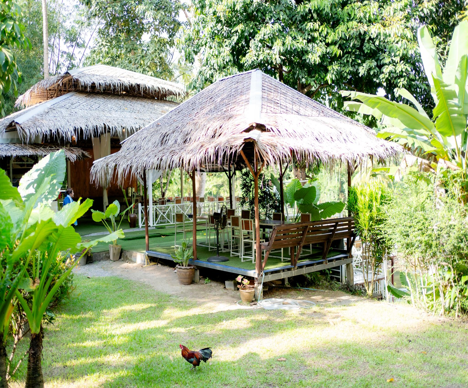

In [101]:
display(raw_image.resize((468, 388)))

### Instructed zero-shot vision-to-language detailed caption generation

In [102]:
base64_image = encode_image(test_image)

inputs = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Fill in the blank: this is a photo of a {}"

                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens":256
  }

In [103]:
%%time
response = run_inference(endpoint_name, inputs)
print(response)

{"id": "chatcmpl-140025934367424", "object": "chat.completion", "created": 1732260290, "choices": [{"index": 0, "message": {"role": "assistant", "content": " this is a photo of Terrace/Patio."}, "logprobs": null, "finish_reason": "eos_token"}], "usage": {"prompt_tokens": 2168, "completion_tokens": 12, "total_tokens": 2180}}
CPU times: user 18.4 ms, sys: 12 μs, total: 18.4 ms
Wall time: 1.15 s


## batch test for acc & time

In [97]:
test_json_file = '/home/ec2-user/SageMaker/klook/data0527/test_16.json'

with open(test_json_file, "r") as f:
    # Parse the JSON data and store it in a variable
    data = json.load(f)


In [99]:
data[1]['images']

'img/392.jpg'

In [91]:
from tqdm import tqdm

test_json_file = '/home/ec2-user/SageMaker/klook/data0527/test_16.json'

with open(test_json_file, "r") as f:
    # Parse the JSON data and store it in a variable
    data = json.load(f)
res_ls = []

start_time = time.time()
#loop over test files
for i in tqdm(data):
    output_folder = '/home/ec2-user/SageMaker/klook/data0527'
    image_file = os.path.join(output_folder,i['images'])
    base64_image = encode_image(image_file)
    inputs = {
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Fill in the blank: this is a photo of a {}"

                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                ]
            }
        ],
        "max_tokens":256
      }

    gt_title = i['conversations'][1]['value']
    res = run_inference(endpoint_name, inputs)
    #print ("res: ", res)
    res_dict = {'image': image_file,
                'gt_title': gt_title,
                 'gen_title': res}

    res_ls.append(res_dict)

end_time = time.time()

elapsed_time_in_seconds = end_time - start_time
elapsed_time_in_minutes = elapsed_time_in_seconds / 60 / len(data) * 1000
print(f"Code block took {elapsed_time_in_minutes:.2f} minutes to execute 1000 images")

100%|██████████| 521/521 [08:28<00:00,  1.02it/s]

Code block took 16.27 minutes to execute 1000 images


In [104]:
res_ls[0]

{'image': '/home/ec2-user/SageMaker/klook/data0527/img/360.jpg',
 'gt_title': 'this is a photo of Hallway.',
 'gen_title': '{"id": "chatcmpl-140025933584160", "object": "chat.completion", "created": 1732259673, "choices": [{"index": 0, "message": {"role": "assistant", "content": " this is a photo of Hallway."}, "logprobs": null, "finish_reason": "eos_token"}], "usage": {"prompt_tokens": 2364, "completion_tokens": 9, "total_tokens": 2373}}'}

In [106]:
res_ls[1]

{'image': '/home/ec2-user/SageMaker/klook/data0527/img/392.jpg',
 'gt_title': 'this is a photo of Terrace/Patio.',
 'gen_title': '{"id": "chatcmpl-140025934119456", "object": "chat.completion", "created": 1732259675, "choices": [{"index": 0, "message": {"role": "assistant", "content": " this is a photo of Terrace/Patio."}, "logprobs": null, "finish_reason": "eos_token"}], "usage": {"prompt_tokens": 2168, "completion_tokens": 12, "total_tokens": 2180}}'}

In [107]:
def cal_acc(res_ls):
    res = 0
    gt_label_ls = []
    pred_ls = []

    for i in tqdm(res_ls):
        gt_label_value = i['gt_title'].split(" ")[-1].replace(".", "")
        pred_value = json.loads(i['gen_title'])["choices"][0]["message"]["content"].split(" ")[-1].replace(".", "")
        gt_label_ls.append(gt_label_value)
        pred_ls.append(pred_value)
        if gt_label_value == pred_value:
            res = res + 1

    print("<<< accuracy: ", res / len(res_ls))
    return gt_label_ls,pred_ls

In [108]:
a,b = cal_acc(res_ls)

100%|██████████| 521/521 [00:00<00:00, 149111.73it/s]

<<< accuracy:  0.9097888675623801


### Instructed Visual Question Answering (VQA)

In [39]:
base64_image = encode_image(test_image)

inputs = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Is it recommended for eating before sport?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens":256
  }

In [40]:
response = run_inference(endpoint_name, inputs)
print(response)

{"id": "chatcmpl-139804181960144", "object": "chat.completion", "created": 1731556675, "choices": [{"index": 0, "message": {"role": "assistant", "content": " Eating before sport is generally recommended to ensure you have the right energy levels for your activity. Carbohydrates are the body's preferred source of fuel, so including some carbohydrate-rich foods in your meal before playing sports can help replenish energy stores and improve performance.\n\nIt's important to eat appropriate sports nutrition foods that can provide sustained energy, such as complex carbohydrates and aim for a balance of carbohydrates, proteins, and fats. Avoid consuming foods that are too high in fat or may cause gastrointestinal distress, as these can lead to sluggishness or discomfort during activity.\n\nOn the other hand, some people may not feel comfortable eating before sport because of the risk of stomach cramps or other discomfort, which can be painful and disrupt their performance. If this is the cas

In [41]:
base64_image = encode_image(test_image)

inputs = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Can you list several descriptions for product marketing?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens":512
  }

In [42]:
response = run_inference(endpoint_name, inputs)
print(response)

{"id": "chatcmpl-139804182511968", "object": "chat.completion", "created": 1731556679, "choices": [{"index": 0, "message": {"role": "assistant", "content": " High-angle drone shot showcasing a sprawling resort complex, featuring multiple buildings constructed in a charming European architectural style with brown roofs, surrounded by a serene golf course. The central area offers a large swimming pool framed by lounge chairs and towels, with a picturesque view of a reflective lake or pond. The resort is set against a landscape of lush green trees and is nestled within a natural setting, providing a tranquil and luxurious vacation destination. "}, "logprobs": null, "finish_reason": "eos_token"}], "usage": {"prompt_tokens": 2165, "completion_tokens": 105, "total_tokens": 2270}}


In [43]:
prompt = [
{"role": "system", "content": [{"type": "text", "text": "You are helpful assistant"}, ], },
{"role": "user", "content": [{"type": "text", "text": "Who are you?"}, ], }
]

inputs = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Hi"
                }
            ]
        }
    ],
    "max_tokens":512,
    "temperature": 0.1, 
    "top_p": 0.1
  }

response = run_inference(endpoint_name, inputs)
print(response)

{"id": "chatcmpl-139804182774064", "object": "chat.completion", "created": 1731556681, "choices": [{"index": 0, "message": {"role": "assistant", "content": " Hello! How can I help you today? Is there something you would like to know or discuss? I'm here to answer any questions you may have. "}, "logprobs": null, "finish_reason": "eos_token"}], "usage": {"prompt_tokens": 10, "completion_tokens": 34, "total_tokens": 44}}


## Clean up
Uncomment the below cell to delete the endpoint and model when you finish the experiment

In [76]:
sm_client.delete_model(ModelName=deploy_model_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '30f8acd4-2583-421a-a676-94e98dd192c9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '30f8acd4-2583-421a-a676-94e98dd192c9',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 22 Nov 2024 07:05:13 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}